# TenSEAL Demo

## Setup

All modules are imported here, make sure everything is installed by running the cell below

In [1]:
import torch
from torchvision import transforms
from random import randint
import pickle
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from typing import Dict


import tenseal as ts

def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

### Plain tensor creation


In [2]:
lhs = ts.plain_tensor([1,2,3,4], [2,2])
rhs = ts.plain_tensor([5,6,7,8], [2,2])

lhs_list = ts.tolist(lhs)
rhs_list = ts.tolist(rhs)

print(" Shape = {}".format(lhs.shape()))
print(" Plain Data = {}".format(lhs_list))

 Shape = [2, 2]
 Plain Data = [[1.0, 2.0], [3.0, 4.0]]


### Encrypted tensor creation

In [3]:
elhs = ts.ckks_tensor(context, lhs)
erhs = ts.ckks_tensor(context, rhs)
print(" Shape = {}".format(lhs.shape()))
print(" Encrypted Data = {}.".format(elhs.data()))

 Shape = [2, 2]
 Encrypted Data = [<_tenseal_cpp.Ciphertext object at 0x7f284f26f930>, <_tenseal_cpp.Ciphertext object at 0x7f284f26feb0>, <_tenseal_cpp.Ciphertext object at 0x7f284f26fef0>, <_tenseal_cpp.Ciphertext object at 0x7f284f26ff70>].


## Basic operations

In [4]:
def decrypt(enc):
    return ts.tolist(enc.decrypt())

### Addition

In [5]:
result = elhs + erhs
print("{} + {} = {}.".format(lhs_list, rhs_list, decrypt(result)))

[[1.0, 2.0], [3.0, 4.0]] + [[5.0, 6.0], [7.0, 8.0]] = [[5.999999999842063, 7.999999996754072], [10.000000004160178, 12.000000002494286]].


### Subtraction

In [6]:
result = elhs - erhs
print("{} - {} = {}.".format(lhs_list, rhs_list, decrypt(result)))

[[1.0, 2.0], [3.0, 4.0]] - [[5.0, 6.0], [7.0, 8.0]] = [[-4.0000000006843575, -4.000000001215222], [-4.000000000708685, -4.00000000115827]].


### Multiplication

In [7]:
result = elhs * erhs
print("Multiplication: {} * {} = {}.".format(lhs_list, rhs_list, decrypt(result)))

Multiplication: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]] = [[5.000000665396242, 12.000001593678462], [21.000002835666237, 32.000004303092325]].


### Multiplication with plain tensor

In [8]:
plain = ts.plain_tensor([5,6,7,8], [2,2])
result = elhs * plain

print("{} * {} = {}.".format(lhs_list, ts.tolist(plain), decrypt(result)))

[[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]] = [[5.000000667373509, 12.000001592342777], [21.000002826416207, 32.000004290801286]].


### Power

In [9]:
result = elhs ** 3
print("{} ^ 3 = {}.".format(lhs_list, decrypt(result)))

[[1.0, 2.0], [3.0, 4.0]] ^ 3 = [[1.0000008059284933, 8.000006403999585], [27.000021765816122, 64.00005153196267]].


### Polynomial evaluation $1 + X^2 + X^3$

In [10]:
result = elhs.polyval([1,0,1,1])

print("X = {}".format(lhs_list))
print("1 + X^2 + X^3 = {}.".format(decrypt(result)))

X = [[1.0, 2.0], [3.0, 4.0]]
1 + X^2 + X^3 = [[3.0000009365159723, 13.000006926158992], [37.00002298073139, 81.00005368125807]].


### Sigmoid approximation
$\sigma(x) = 0.5 + 0.197 x - 0.004 x^3$

Ref: https://eprint.iacr.org/2018/462.pdf

In [11]:
result = elhs.polyval([0.5, 0.197, 0, -0.004])


print("X = {}".format(lhs_list))
print("0.5 + 0.197 X - 0.004 x^X = {}.".format(decrypt(result)))


X = [[1.0, 2.0], [3.0, 4.0]]
0.5 + 0.197 X - 0.004 x^X = [[0.6930000209078732, 0.8620000234150662], [0.9829999415815087, 1.031999876509533]].


# Encrypted inference demo

## Client Helpers

In [34]:
def create_ctx():
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = 2 ** 21
    ctx.generate_galois_keys()
    return ctx


def load_input():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    idx = randint(1, 350)
    img_name = "samples/img_{}.jpg".format(idx)
    img = Image.open(img_name)
    print("sampled {}".format(img_name))
    imshow(np.asarray(img))
    return transform(img).view(28, 28).tolist()

def prepare_input(ctx, plain_input):
    enc_input, windows_nb = ts.im2col_encoding(ctx, plain_input, 7, 7, 3)
    assert windows_nb == 64
    return enc_input

## Server Model

In [40]:
class ConvMNIST():
    """CNN for classifying MNIST data.
    Input should be an encoded 28x28 matrix representing the image.
    TenSEAL can be used for encoding `tenseal.im2col_encoding(ctx, input_matrix, 7, 7, 3)`
    The input should also be normalized with a mean=0.1307 and an std=0.3081 before encryption.
    """

    def __init__(self, parameters: Dict[str, list]):
        self.conv1_weight = parameters["conv1_weight"]
        self.conv1_bias = parameters["conv1_bias"]
        self.fc1_weight = parameters["fc1_weight"]
        self.fc1_bias = parameters["fc1_bias"]
        self.fc2_weight = parameters["fc2_weight"]
        self.fc2_bias = parameters["fc2_bias"]
        self.windows_nb = parameters["windows_nb"]

    def forward(self, enc_x: ts.CKKSVector) -> ts.CKKSVector:
        # conv layer
        channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, self.windows_nb) + bias
            channels.append(y)
        out = ts.CKKSVector.pack_vectors(channels)
        # squaring
        out.square_()
        # no need to flat
        # fc1 layer
        out.mm_(self.fc1_weight).add_plain_(self.fc1_bias)
        # squaring
        out.square_()
        # output layer
        out.mm_(self.fc2_weight).add_plain_(self.fc2_bias)
        return out

    @staticmethod
    def prepare_input(context: bytes, ckks_vector: bytes) -> ts.CKKSVector:
        try:
            ctx = ts.context_from(context)
            enc_x = ts.ckks_vector_from(ctx, ckks_vector)
        except:
            raise DeserializationError("cannot deserialize context or ckks_vector")
        try:
            _ = ctx.galois_keys()
        except:
            raise InvalidContext("the context doesn't hold galois keys")

        return enc_x
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

## Server helpers

In [41]:
import pickle
import os

def load_parameters(file_path: str) -> dict:
    try:
        parameters = pickle.load(open(file_path, "rb"))
        print(f"Model loaded from '{file_path}'")
    except OSError as ose:
        print("error", ose)
        raise ose
    return parameters



parameters = load_parameters("parameters/ConvMNIST-0.1.pickle")
model = ConvMNIST(parameters)

Model loaded from 'parameters/ConvMNIST-0.1.pickle'


## Client Query

sampled samples/img_268.jpg


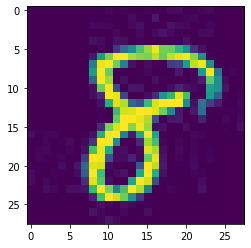

In [42]:
context = create_ctx()
image = load_input()

encrypted_image = prepare_input(context, image)
print(encrypted_image)

server_context = context.serialize()
encrypted_image = encrypted_image.serialize()

client_query = {
    "data" : encrypted_image,
    "context" : server_context,
}

## Server inference

In [43]:
encrypted_query = model.prepare_input(server_context, encrypted_image)
encrypted_result = model(encrypted_query).serialize()

server_response = {
    "data" : encrypted_result
}


## Client process response

In [44]:
result = ts.ckks_vector_from(context, encrypted_result).decrypt()

probs = torch.softmax(torch.tensor(result), 0)
label_max = torch.argmax(probs)
print("Maximum probability for label {}".format(label_max))


Maximum probability for label 8
